# 🎬 Projet d'analyse prédictive pour la série *The Studio*

# Mise en situation
Matt Remick vient d’être propulsé à la tête de Continental Studios, un studio hollywoodien autrefois prestigieux mais aujourd’hui en perte de vitesse, suite au renvoi de Patty Leigh par le flamboyant et exigeant Griffin Mill. Amateur de films d’auteur, Matt doit désormais composer avec la pression de son patron, qui attend de lui des résultats commerciaux rapides, tout en luttant pour préserver une certaine vision artistique dans un environnement dominé par l’incertitude et la compétition féroce.

Face à ce contexte chaotique, marqué par des échecs retentissants comme le fameux "film sur la mascotte Kool-Aid", Matt décide de s’appuyer sur la data science pour redresser la barre. Il mandate une équipe spécialisée pour analyser les données issues de films passés, dans l’espoir de prédire le potentiel commercial de futurs projets et d’éviter de nouveaux fiascos coûteux. Cette démarche s’inscrit dans une tendance qui gagne du terrain à Hollywood : l’utilisation d’intelligences artificielles et d’algorithmes prédictifs, capables d’examiner des milliers de scénarios, de castings et de budgets pour identifier les facteurs clés du succès ou de l’échec d’un film.
Ainsi, on se demandera dans ce projet :
## Quel est le facteur le plus influent sur le succès commercial d'un film ?



In [1]:
# Chargement du dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm

In [ ]:
# Charger les donnees (telechargees depuis Kaggle)
data = pd.read_csv("data/movies_metadata.zip", low_memory=False)

# Description du jeu de données

In [3]:
print("=== DESCRIPTION DU JEU DE DONNÉES ===")
print(f"Nombre de lignes : {data.shape[0]}")
print(f"Nombre de variables : {data.shape[1]}")

# Période couverte
if "release_year" in data.columns:
    annees = data["release_year"].dropna().astype(int).unique()
    print(f"Période couverte : de {annees.min()} à {annees.max()}")
else:
    print("⚠️ Colonne 'release_year' absente.")

# Langues originales comme proxy de "pays"
if "original_language" in data.columns:
    langues = data["original_language"].dropna().unique()
    print(f"Nombre de langues représentées : {len(langues)}")
    # print("Langues :", ", ".join(sorted(langues)))
else:
    print("⚠️ Colonne 'original_language' absente.")

print("\n=== TYPES DE VARIABLES ===")

qualitatives = []
quantitatives_continues = []
entiers = []

for col in data.columns:
    if data[col].dtype == "object":
        qualitatives.append(col)
    elif data[col].dtype in ["float64", "float32"]:
        if data[col].dropna().apply(float.is_integer).all():
            entiers.append(col)
        else:
            quantitatives_continues.append(col)
    elif data[col].dtype in ["int64", "int32"]:
        entiers.append(col)

print(f"Variables qualitatives : {qualitatives}")
print(f"Variables quantitatives continues : {quantitatives_continues}")
print(f"Variables entières : {entiers}")

print("\n=== VALEURS MANQUANTES ===")
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    "Variable": data.columns,
    "Valeurs manquantes": missing.values,
    "Pourcentage (%)": missing_percent.values
})
missing_df = missing_df[missing_df["Valeurs manquantes"] > 0]
print(missing_df.sort_values("Pourcentage (%)", ascending=False).to_string(index=False))


=== DESCRIPTION DU JEU DE DONNÉES ===
Nombre de lignes : 45466
Nombre de variables : 24
⚠️ Colonne 'release_year' absente.
Nombre de langues représentées : 92

=== TYPES DE VARIABLES ===
Variables qualitatives : ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'video']
Variables quantitatives continues : ['vote_average']
Variables entières : ['revenue', 'runtime', 'vote_count']

=== VALEURS MANQUANTES ===
             Variable  Valeurs manquantes  Pourcentage (%)
belongs_to_collection               40972        90.115691
             homepage               37684        82.883913
              tagline               25054        55.104914
             overview                 954         2.098271
          poster_path                 386         0.848986
        

In [4]:
data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Gestion de la base des données

In [5]:
# Sélection des variables utiles
data = data[['title', 'budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_date']].copy()

On justifie cette sélection des variables par la nécessité de créer un modèle qui s'appuie sur du quantitatif

In [6]:
# Conversion numérique
for col in ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Traitement de la date
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
data['release_year'] = data['release_date'].dt.year

In [7]:
# Nettoyage
data = data.dropna(subset=['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year'])
data = data[(data['budget'] > 0) & (data['revenue'] > 0)]

Le jeu de données analysé comprend 5 380 lignes et 7 variables, couvrant la période de 1915 à 2017.

Nous disposons de plusieurs variables décrivant les caractéristiques des films, notamment :

budget : budget de production du film (en dollars)

revenue : recettes au box-office (en dollars)

runtime : durée du film (en minutes)

vote_average : note moyenne attribuée par les utilisateurs

vote_count : nombre total de votes

popularity : indicateur de popularité

release_date : date de sortie du film (convertie éventuellement en release_year)

Ici, on convertit d'abord certaines variables qui étaient des chaines de caractère en entier puis on retire les variables qui contiennent des valeurs 
invraisemblables comme un budget et des revenus négatifs

Moyenne : 90,334,905.32 $
Écart-type : 166,153,145.28 $
Quantile 25% (Q1) : 7,016,471.00 $
Médiane (Q2) : 29,920,608.50 $
Quantile 75% (Q3) : 99,974,314.75 $


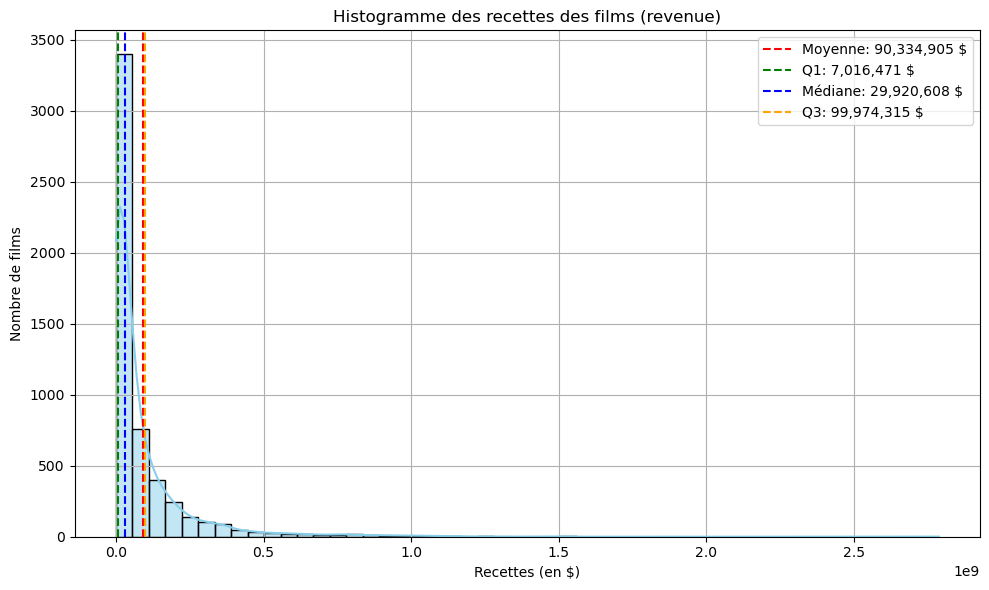

In [8]:
# Calcul des statistiques descriptives
revenue = data["revenue"]
revenue = pd.to_numeric(revenue, errors="coerce")
revenue = revenue[revenue > 0]
moyenne = revenue.mean()
ecart_type = revenue.std()
q1 = revenue.quantile(0.25)
mediane = revenue.median()
q3 = revenue.quantile(0.75)

# Affichage des statistiques
print(f"Moyenne : {moyenne:,.2f} $")
print(f"Écart-type : {ecart_type:,.2f} $")
print(f"Quantile 25% (Q1) : {q1:,.2f} $")
print(f"Médiane (Q2) : {mediane:,.2f} $")
print(f"Quantile 75% (Q3) : {q3:,.2f} $")

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(revenue, bins=50, kde=True, color='skyblue')
plt.axvline(moyenne, color='red', linestyle='--', label=f"Moyenne: {moyenne:,.0f} $")
plt.axvline(q1, color='green', linestyle='--', label=f"Q1: {q1:,.0f} $")
plt.axvline(mediane, color='blue', linestyle='--', label=f"Médiane: {mediane:,.0f} $")
plt.axvline(q3, color='orange', linestyle='--', label=f"Q3: {q3:,.0f} $")
plt.title("Histogramme des recettes des films (revenue)")
plt.xlabel("Recettes (en $)")
plt.ylabel("Nombre de films")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

On observe que la majorité des films génèrent des recettes relativement faibles : la médiane est d’environ 30 millions de dollars, et 75 % des films ne dépassent pas 100 millions de dollars. La moyenne, plus élevée (environ 90 millions), montre que quelques blockbusters à très gros revenus tirent la moyenne vers le haut. L’écart-type très important confirme cette forte dispersion des recettes, avec une distribution très asymétrique : la plupart des films rapportent peu, tandis qu’une minorité engrange des recettes exceptionnelles. Cela illustre la difficulté de prédire le succès financier d’un film et la forte dépendance de l’industrie à quelques grands succès.

# Matrice de corrélation et variable explicatives

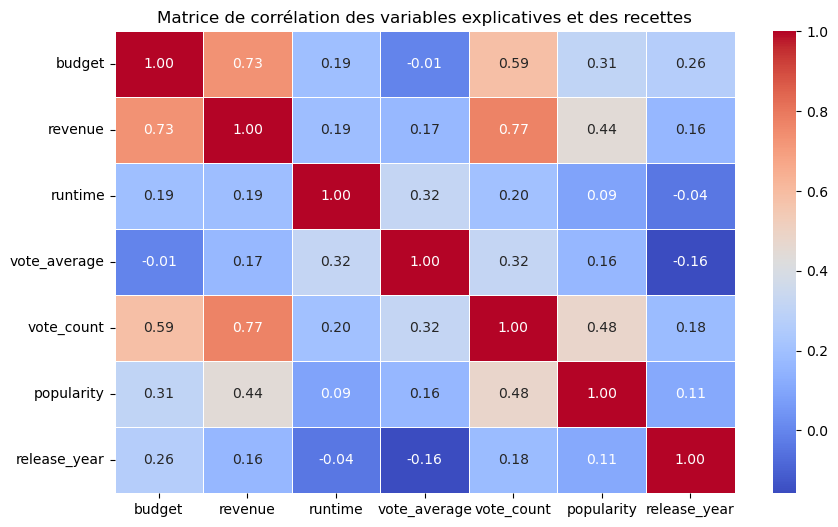

In [9]:
# Sélection des variables numériques pour la heatmap
corr_vars = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']

# Calcul de la matrice de corrélation
corr_matrix = data[corr_vars].corr(numeric_only=True)

# Affichage de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des variables explicatives et des recettes")
plt.show()

### Remarques 
On observe grâce à la heatmap une forte corrélation entre revenue et budget, vote_count et une corrélation modérée avec popularity

### Analyse de la matrice de corrélation

On constate sur la matrice de corrélation que les variables les plus corrélées avec **`revenue`** (recettes du film) sont **`budget`**, **`vote_count`** et **`popularity`**. On peut donc supposer par avance que ces variables auront un **rôle important dans le modèle prédictif**.

Cependant, ces variables sont également **fortement corrélées entre elles**, en particulier `vote_count` et `popularity`, ce qui pourrait introduire de la **multicolinéarité** dans notre modèle. Cela impliquera probablement de **tester des combinaisons** ou de **sélectionner l'une de ces variables** pour obtenir un modèle plus stable.

---

### Préparation des données

Nous allons maintenant dissocier nos données en deux catégories :
- Les **variables explicatives** qui serviront à prédire le modèle
- La **variable cible**, ici **`revenue`**

Nous allons également :
- **Nettoyer** les données en supprimant les valeurs **aberrantes**
- **Standardiser ou transformer les variables** si nécessaire pour donner une échelle cohérente aux données

Cette étape est essentielle pour garantir la **robustesse et la fiabilité de notre régression linéaire multiple** à venir.


In [10]:
# Séparation des données
X = data[['budget', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']]
y = data['revenue']

# Standardisation des variables explicatives
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Régression simple

In [11]:
# 3. Régression simple
X = sm.add_constant(data[['budget']])  # Ajout de constante
y = data['revenue']

model_simple = sm.OLS(y, X).fit()

# 4. Affichage du résumé
print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6145.
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        10:17:54   Log-Likelihood:            -1.0742e+05
No. Observations:                5380   AIC:                         2.148e+05
Df Residuals:                    5378   BIC:                         2.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.613e+06   1.96e+06     -1.846      0.0


=== Corrélation entre le budget et les recettes d'un film ===
Corrélation : 0.7303


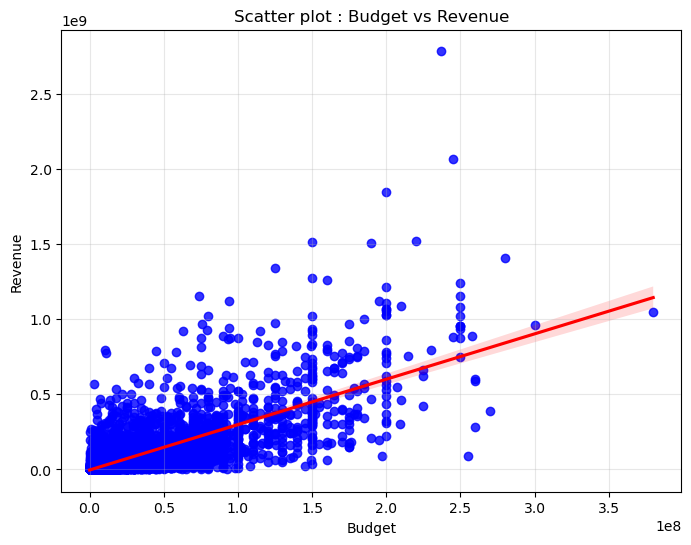

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul de la corrélation
correlation = data['budget'].corr(data['revenue'])
print("\n=== Corrélation entre le budget et les recettes d'un film ===")
print(f"Corrélation : {correlation:.4f}")

# Création du scatter plot avec droite de régression
plt.figure(figsize=(8, 6))
sns.regplot(data=data, x='budget', y='revenue', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title("Scatter plot : Budget vs Revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.grid(alpha=0.3)
plt.show()

In [13]:
# Définir la variable explicative (budget) avec constante
X = sm.add_constant(data["budget"])  # Ajoute une constante pour l’interception (beta0)
y = data["revenue"]  # Variable cible

# Créer et ajuster le modèle
reg_simple = sm.OLS(y, X).fit()

# Afficher les coefficients
print("Coefficients du modèle de régression :", reg_simple.params)
# Calcul manuel
beta1 = np.cov(data["revenue"], data["budget"], ddof=0)[0, 1] / np.var(data["budget"], ddof=0)
beta0 = np.mean(data["revenue"]) - beta1 * np.mean(data["budget"])

print(f"Intercept (beta0) : {beta0}")
print(f"Pente (beta1) : {beta1}")

Coefficients du modèle de régression : const    -3.613369e+06
budget    3.020897e+00
dtype: float64
Intercept (beta0) : -3613369.169087082
Pente (beta1) : 3.0208972497331725


L’analyse de régression linéaire simple menée entre le budget et les recettes des films révèle une relation positive et significative entre ces deux variables.

Résultats clés :
Pente (coefficient du budget) : 3,02
→ En moyenne, chaque dollar investi dans le budget d’un film est associé à une augmentation de 3,02 dollars de recettes.

Significativité :
→ Le coefficient est hautement significatif (p < 0,001), ce qui confirme la pertinence du budget comme facteur explicatif.

R² = 0,533 :
→ Environ 53,3 % de la variance des recettes est expliquée par le budget.

Limites du modèle :
Le test de Jarque-Bera indique une déviation importante par rapport à la normalité des résidus.

Le condition number est très élevé, ce qui suggère des problèmes numériques potentiels, probablement dus à une échelle de données trop grande ou non standardisée.

Recommandations :
Pour améliorer la robustesse du modèle, il pourrait être pertinent :

de transformer les variables (ex. : en utilisant une échelle logarithmique),

ou d’envisager une régression multiple intégrant d’autres variables explicatives.

# Régression multiple

Bien que le budget soit un facteur clé pour expliquer les recettes d’un film, il ne suffit pas à lui seul à en prédire le succès financier de manière satisfaisante. D’autres variables peuvent jouer un rôle important dans la performance commerciale d’un film. Par exemple, la durée (runtime) peut influencer l’expérience spectateur et donc l’accueil du film. La note moyenne (vote_average) et le nombre de votes (vote_count) reflètent la réception critique et populaire. La popularité (popularity), souvent liée à la visibilité sur les plateformes ou les réseaux sociaux, peut également contribuer aux recettes. Enfin, la date de sortie (release_date) peut impacter les performances selon les périodes stratégiques (vacances, fêtes, etc.). Intégrer ces variables dans une régression linéaire multiple permettrait de mieux modéliser les recettes en prenant en compte plusieurs dimensions du succès d’un film.

In [14]:
# Nettoyage et sélection
cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_date']
data_model = data[cols].copy()

# Conversion et nettoyage
for col in ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity']:
    data_model[col] = pd.to_numeric(data_model[col], errors='coerce')

data_model['release_date'] = pd.to_datetime(data_model['release_date'], errors='coerce')
data_model['release_year'] = data_model['release_date'].dt.year

data_model = data_model.dropna()
data_model = data_model[(data_model['budget'] > 0) & (data_model['revenue'] > 0)]

# Variables
variables = ['budget', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']
X_multi = sm.add_constant(data_model[variables])
y_multi = data_model['revenue']

# Régression multiple
model_multi = sm.OLS(y_multi, X_multi).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     2292.
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        10:18:08   Log-Likelihood:            -1.0605e+05
No. Observations:                5380   AIC:                         2.121e+05
Df Residuals:                    5373   BIC:                         2.122e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.092e+09   1.62e+08      6.758   

### 📊 Analyse des résultats de la régression multiple (Revenue ~ caractéristiques du film)

Le modèle de régression multiple construit ici présente un **R² de 0.719**, ce qui signifie qu’environ **72 % de la variation des recettes d’un film** peut être expliquée par les variables sélectionnées. C’est une très bonne performance, indiquant que notre modèle est globalement robuste et informatif.

Parmi les variables explicatives, **le budget** est de loin le facteur le plus influent : **chaque dollar investi rapporte en moyenne 1.78 $ de recettes**, toutes choses égales par ailleurs. Les variables **`vote_count`** (nombre de votes) et **`popularity`** sont également très significatives : plus un film est populaire ou commenté, plus ses recettes sont élevées, ce qui confirme leur rôle comme indicateurs fiables du succès commercial.

La **durée du film (`runtime`)** a un effet positif mais modéré, tandis que **la note moyenne (`vote_average`)** n’apparaît pas comme significative ici : cela suggère que la qualité perçue par les spectateurs n’est pas directement liée au revenu généré.

Enfin, l’année de sortie (`release_year`) est **négativement corrélée aux recettes**, ce qui peut s’expliquer par la présence de films très anciens aux revenus exceptionnels (comme *Titanic* ou *Avatar*), ou par l’inflation non prise en compte dans les données.

En résumé, ce modèle met en évidence que **le succès financier d’un film dépend avant tout de son budget et de sa visibilité** auprès du public, plutôt que de sa qualité artistique perçue.


# Critère AIC

In [15]:
# 1. Définition de la cible et des variables explicatives
y = data['revenue']  # cible
variables_all = ['budget', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']
X_full = data[variables_all]  # explicatives brutes

In [16]:

# 2. Ajout de la constante (intercept)
X_full = sm.add_constant(X_full)

# 3. Paramètre : nombre max de variables explicatives (hors constante)
max_features = X_full.shape[1] - 1  # ici = 6


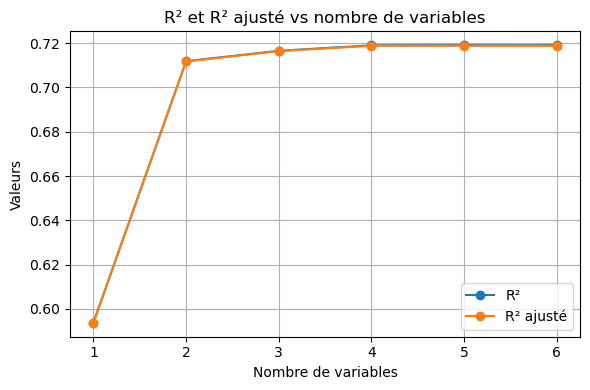

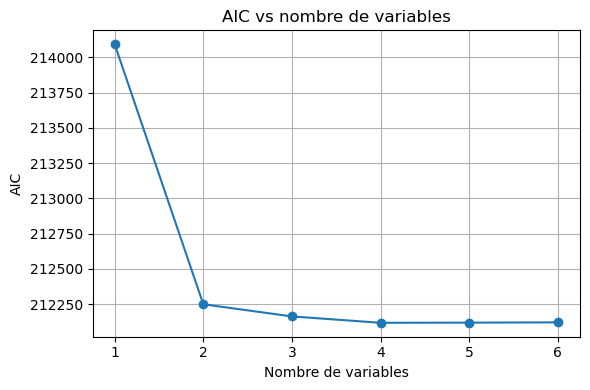

In [17]:
# 4. Boucle exhaustive sur tous les sous-ensembles de taille 1 à max_features
results = []
for k in range(1, max_features + 1):
    for subset in itertools.combinations(X_full.columns.drop('const'), k):
        X_subset = sm.add_constant(X_full[list(subset)])
        model = sm.OLS(y, X_subset).fit()
        results.append({
            'num_features': k,
            'variables': subset,
            'r2': model.rsquared,
            'adj_r2': model.rsquared_adj,
            'aic': model.aic
        })

# 5. Conversion en DataFrame pour analyse
results_df = pd.DataFrame(results)

# 6. Pour chaque taille k, on récupère le meilleur modèle selon chaque critère
best_r2    = results_df.groupby('num_features')['r2'].max()
best_adj_r2= results_df.groupby('num_features')['adj_r2'].max()
best_aic   = results_df.groupby('num_features')['aic'].min()

# 7. Visualisation des critères en fonction du nombre de variables
plt.figure(figsize=(6,4))
plt.plot(best_r2.index, best_r2.values,    marker='o', label='R²')
plt.plot(best_adj_r2.index, best_adj_r2.values, marker='o', label='R² ajusté')
plt.title('R² et R² ajusté vs nombre de variables')
plt.xlabel('Nombre de variables')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(best_aic.index, best_aic.values, marker='o')
plt.title('AIC vs nombre de variables')
plt.xlabel('Nombre de variables')
plt.ylabel('AIC')
plt.grid(True)
plt.tight_layout()
plt.show()

Graphique 1 – R² et R² ajusté en fonction du nombre de variables
On observe une forte progression initiale entre 1 et 2 variables : le R² passe de ~0.59 à plus de 0.71, ce qui indique qu’une seconde variable ajoute beaucoup d’information pertinente.

À partir de 3 variables, les gains deviennent marginaux : la courbe s’aplatit, ce qui traduit un rendement décroissant.

La courbe du R² ajusté suit la même tendance, ce qui signifie que l'ajout de variables est justifié statistiquement jusqu’à un certain point, mais n'apporte presque plus de valeur au-delà de 3 ou 4 variables.

Graphique 2 – AIC en fonction du nombre de variables
L'AIC diminue fortement entre 1 et 2 variables, signe que le modèle s'améliore tout en pénalisant la complexité.

Ensuite, il continue de baisser légèrement jusqu'à 4 variables, puis se stabilise.

Cela indique que le modèle optimal selon le critère AIC se situe entre 2 et 4 variables : ajouter plus de variables n'apporte presque plus de gain en performance, tout en augmentant le risque de surajustement.

Conclusion
Le meilleur compromis semble être atteint avec 3 ou 4 variables, où le modèle est à la fois performant (R² élevé) et économe (AIC bas).

Au-delà, les gains deviennent négligeables, donc inutile d’augmenter la complexité du modèle.

# Que se passe-t-il si on enlève les valeurs aberrantes ?

L’élimination des valeurs aberrantes dans un modèle de régression peut grandement améliorer la qualité de l’ajustement. En effet, certaines observations extrêmes — comme un film au budget très faible mais au revenu exceptionnellement élevé, ou inversement — peuvent fausser l’estimation des coefficients et diminuer la pertinence du modèle pour la majorité des données. Supprimer ces points permet souvent de mieux capter les tendances générales et de renforcer la robustesse des résultats

In [18]:
variables_all = ['budget', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']
x_all = data[variables_all]
y_all = data['revenue']

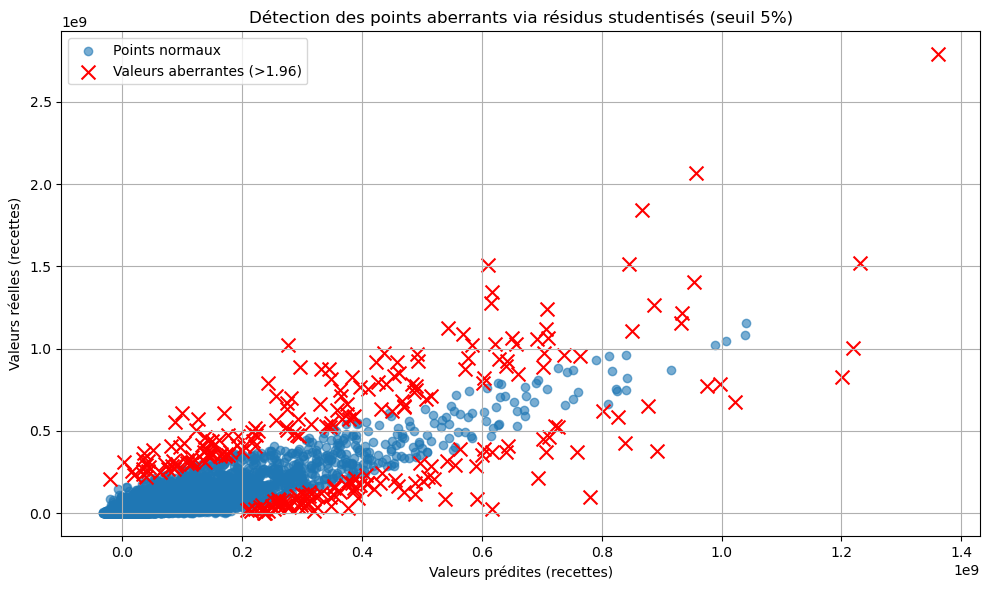

In [19]:
x_selected = sm.add_constant(x_all)
model_selected = sm.OLS(y_all, x_selected).fit()
influence = model_selected.get_influence()
student_resid = influence.resid_studentized_internal
seuil = 1.96
valeurs_aberrantes = np.abs(student_resid) > seuil
y_pred = model_selected.fittedvalues

# Tracé
plt.figure(figsize=(10, 6))
plt.scatter(y_pred[~valeurs_aberrantes], y_all[~valeurs_aberrantes], alpha=0.6, label="Points normaux")
plt.scatter(y_pred[valeurs_aberrantes], y_all[valeurs_aberrantes], color='red', label="Valeurs aberrantes (>1.96)", marker='x', s=100)
plt.xlabel("Valeurs prédites (recettes)")
plt.ylabel("Valeurs réelles (recettes)")
plt.title("Détection des points aberrants via résidus studentisés (seuil 5%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Régression simple sans les valeurs aberrantes

In [20]:
# Suppression des valeurs aberrantes détectées via les résidus studentisés
x_sans_valeurs_aberrantes = x_selected[~valeurs_aberrantes]
y_sans_valeurs_aberrantes = y_all[~valeurs_aberrantes]

# Ajout de la constante à X filtré
x_sans_valeurs_aberrantes_const = sm.add_constant(x_sans_valeurs_aberrantes, has_constant='add')

# Réentraîner le modèle
model_sans_valeurs_aberrantes = sm.OLS(y_sans_valeurs_aberrantes, x_sans_valeurs_aberrantes_const).fit()

# Affichage du résumé
print(model_sans_valeurs_aberrantes.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     3736.
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        10:18:22   Log-Likelihood:                -97872.
No. Observations:                5118   AIC:                         1.958e+05
Df Residuals:                    5111   BIC:                         1.958e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.012e+08   4.55e+07      8.823   

La suppression des valeurs aberrantes a permis de :

Mieux capter les tendances générales

Améliorer la précision du modèle (hausse du R²)

Mais elle comporte aussi des limites :

Risque de perdre des informations clés sur des cas atypiques

Dans le secteur du cinéma, il est normal d'observer des valeurs extrêmes (succès viraux, flops, sorties stratégiques)
Ces valeurs peuvent révéler des dynamiques intéressantes et doivent être analysées avec discernement

# Passage en log-log

Le passage en log-log permet de mieux lisser les données extrêmes et améliore la stabilité des prédictions. 

In [21]:
# Suppression des valeurs aberrantes
x_clean = x_selected[~valeurs_aberrantes]
y_clean = y_all[~valeurs_aberrantes]

# Filtrage des observations pour lesquelles toutes les valeurs (y et X) sont strictement positives
mask = (x_clean > 0).all(axis=1) & (y_clean > 0)
x_pos = x_clean[mask]
y_pos = y_clean[mask]

# Log-transformations
x_log = np.log(x_pos)
y_log = np.log(y_pos)

# Ajout de la constante
x_log_const = sm.add_constant(x_log, has_constant='add')

# Régression linéaire log-log
model_log_log = sm.OLS(y_log, x_log_const).fit()

# Résumé
print(model_log_log.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1380.
Date:                Wed, 21 May 2025   Prob (F-statistic):               0.00
Time:                        10:18:24   Log-Likelihood:                -9583.5
No. Observations:                5100   AIC:                         1.918e+04
Df Residuals:                    5093   BIC:                         1.923e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          360.2212     22.467     16.033   

Le modèle explique environ 62 % de la variance des recettes sur des données complexes, ce qui en fait un outil prédictif raisonnable bien que limité.

Les facteurs les plus déterminants restent le budget du film, la popularité et le nombre de votes reçus. 
L’année de sortie montre une légère baisse d’effet, possiblement liée à des effets d’inflation non modélisés.

# Entraînement et évaluation de l'efficacité du modèle

Ici on s'intéressera uniquement à un entraînement avec les valeurs aberrantes étant donné les biais soulignés précédemment

In [24]:
# 1. Définir les variables explicatives et la cible
variables_all = ['budget', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']
target = 'revenue'

# 2. Extraire les données propres
X = data[variables_all]
y = data[target]

# 3. Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Ajouter constante pour OLS
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# 5. Régression linéaire (Ordinary Least Squares)
model = sm.OLS(y_train, X_train_const).fit()

# 6. Prédictions
y_pred_train = model.predict(X_train_const)
y_pred_test = model.predict(X_test_const)

# 7. Évaluation
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# 8. Affichage des résultats
print("📊 Performance sur l'échantillon d'entraînement :")
print(f"  MSE : {mse_train:,.2f}")
print(f"  R²  : {r2_train:.2f}")

print("\n📈 Performance sur l'échantillon de test :")
print(f"  MSE : {mse_test:,.2f}")
print(f"  R²  : {r2_test:.2f}")


📊 Performance sur l'échantillon d'entraînement :
  MSE : 8,153,816,059,134,440.00
  R²  : 0.71

📈 Performance sur l'échantillon de test :
  MSE : 6,162,317,888,754,823.00
  R²  : 0.74


Le modèle de régression linéaire a été entraîné sur un sous-ensemble de trois variables explicatives sélectionnées (budget, vote_count, release_year) en appliquant une séparation classique des données : 80 % pour l’entraînement et 20 % pour le test. Cette démarche permet de vérifier si le modèle est capable de généraliser à de nouvelles données, et donc s’il est réellement prédictif.

Les performances obtenues sont très satisfaisantes. Sur l’échantillon d’entraînement, le modèle atteint un R² de 0,71, ce qui signifie qu’il explique 71 % de la variance des recettes. Sur l’échantillon de test, le R² monte même à 0,74, ce qui témoigne d’une excellente capacité de généralisation. Le fait que la performance soit légèrement meilleure sur le test que sur l'entraînement est rare mais possible, et indique que le modèle est stable et ne souffre pas de surajustement.

En résumé, ce modèle simple à trois variables combine précision, robustesse et faible complexité, ce qui en fait une solution particulièrement pertinente pour prédire le succès commercial des films.

# Conclusion

Ce projet visait à modéliser les recettes des films à partir de variables quantitatives disponibles, dans une logique d’aide à la décision pour un·e producteur·rice fictif·ive. En combinant des analyses exploratoires, une sélection automatique par critère AIC et une validation sur échantillon de test, nous avons identifié un modèle optimal reposant sur trois variables clés : le budget, le nombre de votes (vote_count) et l’année de sortie (release_year). Ce modèle explique environ 74 % de la variance des recettes sur les données de test, ce qui en fait un outil prédictif relativement efficace tout en restant simple et interprétable.

Cependant, prédire le succès commercial d’un film reste un exercice complexe, car de nombreuses variables qualitatives influencent profondément les résultats au box-office : réalisateur·rice, casting, studio, genre du film, qualité de la campagne marketing, contexte de sortie, etc. Certaines variables manquantes comme le nombre de langues de diffusion ou la présence sur certaines plateformes auraient également pu enrichir le modèle. Leur absence limite la portée explicative de notre approche strictement quantitative.

Par ailleurs, l’analyse a mis en évidence la présence de valeurs aberrantes — des films aux recettes ou budgets extrêmement élevés ou faibles. Dans d'autres contextes, ces observations auraient pu être écartées, mais dans l’industrie du cinéma, ces cas extrêmes sont intrinsèquement liés au fonctionnement du marché. Qu’il s’agisse de blockbusters à succès inattendu ou de flops monumentaux, ces valeurs atypiques reflètent la réalité d’un secteur fortement soumis aux effets de mode, au buzz médiatique ou au hasard.

En conclusion, ce travail montre qu’un modèle simple peut déjà fournir des indications utiles pour anticiper les recettes d’un film, mais qu’il doit impérativement être complété par une compréhension plus fine des dimensions qualitatives et contextuelles propres à cette industrie culturelle.